<a href="https://colab.research.google.com/github/AkankshaK-AI/S6-Assignment/blob/main/EVA7S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#GroupNorm, Layer Norm and L1 regularization 

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations
Image augmentation has been added


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0,7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                      #  # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics



In [ ]:
# We'd need to convert it into Numpy! Above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# # Let's visualize some of the images
# %matplotlib inline
# import matplotlib.pyplot as plt

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [ ]:
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Getting mean and std values for the transforms



In [ ]:

# simple_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.ToTensor(),
#                                       #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
#                                        # Note the difference between (0.1307) and (0.1307,)
#                                        ])
# exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
# exp_data = exp.train_data
# exp_data = exp.transform(exp_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', exp.train_data.size())
# print(' - min:', torch.min(exp_data))
# print(' - max:', torch.max(exp_data))
# print(' - mean:', torch.mean(exp_data))
# print(' - std:', torch.std(exp_data))
# print(' - var:', torch.var(exp_data))

# The model
Increasing the number of parameters and correcting the Max pooling location

In [ ]:
# dropout_value=0.1

class Net(nn.Module):
    def __init__(self, norm=None):
        super(Net, self).__init__()
        # Input Block
        self.norm = norm
        if(norm == 'L'):
          self.convblock1 = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
              nn.LayerNorm(10,6,6),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=28*28,output_size =26*26, RF=3*3

          # CONVOLUTION BLOCK 1
          self.convblock2 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
              nn.LayerNorm(20,6,6),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=26*26,output_size =24*24, RF=5*5

          # Transition block 1
          self.convblock3 = nn.Sequential(
              nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
              # nn.BatchNorm2d(10),
              # nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=24*24,output_size =24*24, RF=5*5
          self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12*12, RF=6*6

          # CONVOLUTION BLOCK 2
          self.convblock4 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
              nn.LayerNorm(16,6,6),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=12*12, output_size = 10*10, RF=10*10
          self.convblock5 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
              nn.LayerNorm(16,6,6),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=10*10, output_size = 8*8, RF=14*14
          self.convblock6 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
              nn.LayerNorm(16,6,6),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=8*8, output_size = 6*6, RF=18*18
          self.convblock7 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
              nn.LayerNorm(16,6,6),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=6*6, output_size = 6*6, RF=22*22

          # OUTPUT BLOCK  
          self.gap = nn.Sequential(
              nn.AvgPool2d(kernel_size=6)
          ) # output_size = 1*1
          self.convblock8 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
          ) # adding parameters after GAP layer

        # for batch normalization
        elif(norm == 'B'):
          self.convblock1 = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
              nn.BatchNorm2d(10),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=28*28,output_size =26*26, RF=3*3

          # CONVOLUTION BLOCK 1
          self.convblock2 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
              nn.BatchNorm2d(20),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=26*26,output_size =24*24, RF=5*5

          # Transition block 1
          self.convblock3 = nn.Sequential(
              nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
              # nn.BatchNorm2d(10),
              # nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=24*24,output_size =24*24, RF=5*5
          self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12*12, RF=6*6

          # CONVOLUTION BLOCK 2
          self.convblock4 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=12*12, output_size = 10*10, RF=10*10
          self.convblock5 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=10*10, output_size = 8*8, RF=14*14
          self.convblock6 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=8*8, output_size = 6*6, RF=18*18
          self.convblock7 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=6*6, output_size = 6*6, RF=22*22

          # OUTPUT BLOCK  
          self.gap = nn.Sequential(
              nn.AvgPool2d(kernel_size=6)
          ) # output_size = 1*1
          self.convblock8 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
          ) # adding parameters after GAP layer

        # for group normalization
        elif(norm == 'G'):
          self.convblock1 = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
              nn.GroupNorm(5,10),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=28*28,output_size =26*26, RF=3*3

          # CONVOLUTION BLOCK 1
          self.convblock2 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
              nn.GroupNorm(10,20),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=26*26,output_size =24*24, RF=5*5

          # Transition block 1
          self.convblock3 = nn.Sequential(
              nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
              # nn.BatchNorm2d(10),
              # nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=24*24,output_size =24*24, RF=5*5
          self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12*12, RF=6*6

          # CONVOLUTION BLOCK 2
          self.convblock4 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
              nn.GroupNorm(8,16),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=12*12, output_size = 10*10, RF=10*10
          self.convblock5 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
              nn.GroupNorm(8,16),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=10*10, output_size = 8*8, RF=14*14
          self.convblock6 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
              nn.GroupNorm(8,16),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=8*8, output_size = 6*6, RF=18*18
          self.convblock7 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
              nn.GroupNorm(8,16),
              nn.ReLU(),
              # nn.Dropout(dropout_value)
          ) # input_size=6*6, output_size = 6*6, RF=22*22

          # OUTPUT BLOCK  
          self.gap = nn.Sequential(
              nn.AvgPool2d(kernel_size=6)
          ) # output_size = 1*1
          self.convblock8 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
          ) # adding parameters after GAP layer

         # self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net('L').to(device)
summary(model, input_size=(1, 28, 28))

cuda


RuntimeError: ignored

# Training and Testing



Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = [] # train accuracy
test_acc = [] #test accuracy
misclassified=[]

def train(model, device, train_loader, optimizer, epoch, L1=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # L1 loss
    l1=0
    factor=0
    if (norm == 'B'):
      if L1:
      factor=0.001
      for parameter in model.parameters():
        l1=l1+torch.sum(abs(parameter))

    # Sum of losses(cross entropy and L1)
    loss=loss+(factor*l1)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, misclassified):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for i in range(len(pred)):
              if pred[i]!= target[i]:
                misclassified.append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()



    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt

def plot_misclassified(misclassified):
  fig = plt.figure(figsize = (10,10))
  for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(misclassified[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        
        sub.set_title("Pred={}, Act={}".format(str(misclassified[i][1].data.cpu().numpy()),str(misclassified[i][2].data.cpu().numpy())))
        
  plt.tight_layout()

  plt.show()

# Let's Train and test our model

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Loss=0.08357563614845276 Batch_id=468 Accuracy=85.14: 100%|██████████| 469/469 [00:26<00:00, 17.97it/


Test set: Average loss: 0.0922, Accuracy: 9787/10000 (97.87%)

EPOCH: 1


Loss=0.06289342790842056 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]



Test set: Average loss: 0.0669, Accuracy: 9814/10000 (98.14%)

EPOCH: 2


Loss=0.06815129518508911 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]



Test set: Average loss: 0.0374, Accuracy: 9897/10000 (98.97%)

EPOCH: 3


Loss=0.04836501181125641 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]



Test set: Average loss: 0.0310, Accuracy: 9916/10000 (99.16%)

EPOCH: 4


Loss=0.01563950814306736 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:25<00:00, 18.09it/s]



Test set: Average loss: 0.0309, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.012779842130839825 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]



Test set: Average loss: 0.0269, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.04378972575068474 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:25<00:00, 18.04it/s]



Test set: Average loss: 0.0244, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.01341292168945074 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]



Test set: Average loss: 0.0270, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.022641295567154884 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]



Test set: Average loss: 0.0248, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.07828003168106079 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:26<00:00, 17.78it/s]



Test set: Average loss: 0.0231, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.008175207301974297 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]



Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.07340215891599655 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]



Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.036745402961969376 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:26<00:00, 17.85it/s]



Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.002974693663418293 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:26<00:00, 17.90it/s]



Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.02621258608996868 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]



Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.054475221782922745 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:25<00:00, 18.13it/s]



Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Loss=0.006922565866261721 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]



Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.015300584025681019 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s]



Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.020462842658162117 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:26<00:00, 17.93it/s]



Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.012380070984363556 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:26<00:00, 17.52it/s]



Test set: Average loss: 0.0177, Accuracy: 9948/10000 (99.48%)



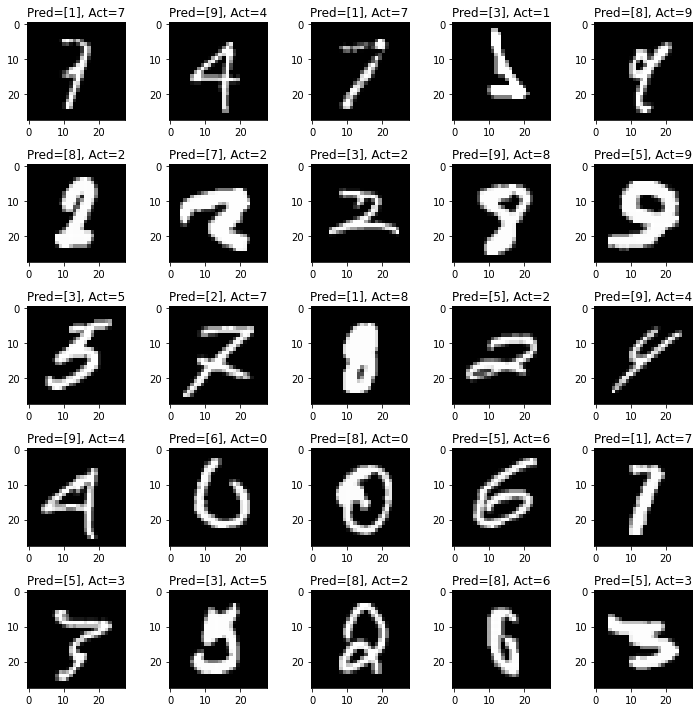

In [ ]:
from torch.optim.lr_scheduler import StepLR  # We have added Step LR here. We will be dropping the LR after every 6 epochs

model =  Net('B').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) #We will be dropping the LR by 0.1 after every 6 epochs

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader, misclassified)


plot_misclassified(misclassified)

Text(0.5, 1.0, 'Test Accuracy')

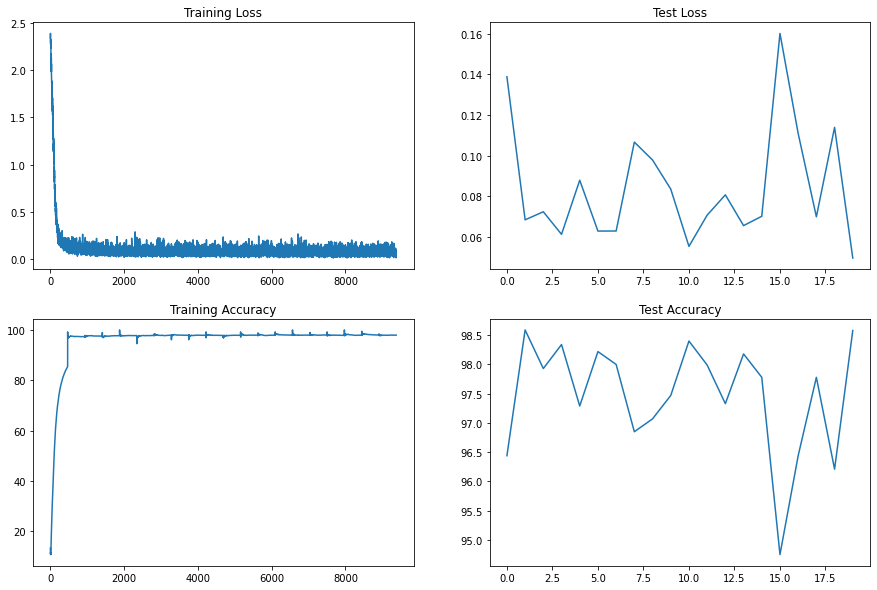

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.16906368732452393 Batch_id=468 Accuracy=72.27: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]



Test set: Average loss: 0.1844, Accuracy: 9586/10000 (95.86%)

EPOCH: 1


Loss=0.1175447404384613 Batch_id=468 Accuracy=96.34: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]



Test set: Average loss: 0.0781, Accuracy: 9800/10000 (98.00%)

EPOCH: 2


Loss=0.0257763359695673 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]



Test set: Average loss: 0.0529, Accuracy: 9862/10000 (98.62%)

EPOCH: 3


Loss=0.0796494409441948 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]



Test set: Average loss: 0.0503, Accuracy: 9858/10000 (98.58%)

EPOCH: 4


Loss=0.01874731108546257 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]



Test set: Average loss: 0.0379, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.024033322930336 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]



Test set: Average loss: 0.0355, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


Loss=0.03135094419121742 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]



Test set: Average loss: 0.0320, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.0678524449467659 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:26<00:00, 17.83it/s]



Test set: Average loss: 0.0284, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Loss=0.013330734334886074 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:26<00:00, 17.63it/s]



Test set: Average loss: 0.0330, Accuracy: 9901/10000 (99.01%)

EPOCH: 9


Loss=0.010993096977472305 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:26<00:00, 17.53it/s]



Test set: Average loss: 0.0241, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.007017822470515966 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:26<00:00, 17.60it/s]



Test set: Average loss: 0.0243, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.00568400276824832 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]



Test set: Average loss: 0.0302, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


Loss=0.040849026292562485 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:26<00:00, 17.76it/s]



Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.02449203096330166 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]



Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.004599059000611305 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:26<00:00, 17.67it/s]



Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.0018103626789525151 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:26<00:00, 17.69it/s]



Test set: Average loss: 0.0255, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.03128006309270859 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]



Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.08966588973999023 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]



Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.02028084732592106 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]



Test set: Average loss: 0.0241, Accuracy: 9924/10000 (99.24%)

EPOCH: 19


Loss=0.010338339023292065 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]



Test set: Average loss: 0.0222, Accuracy: 9935/10000 (99.35%)



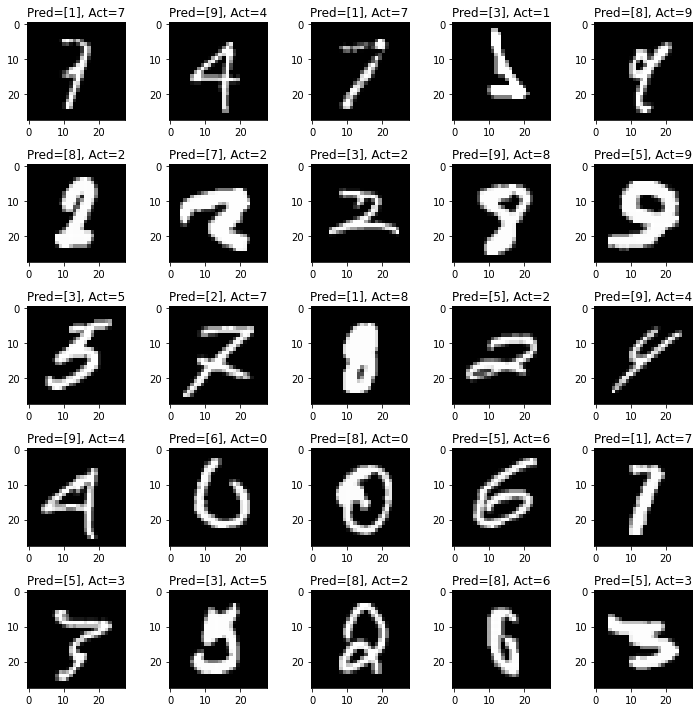

In [ ]:
model =  Net('G').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) #We will be dropping the LR by 0.1 after every 6 epochs

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader, misclassified)


plot_misclassified(misclassified)

In [ ]:
model =  Net('B').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) #We will be dropping the LR by 0.1 after every 6 epochs

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, L1=True)
    test(model, device, test_loader, misclassified)


plot_misclassified(misclassified)